# Import Dependencies

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Reshape, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import requests
import json
api_key = os.getenv("API_KEY")

# Get data

In [ ]:
url = f"https://api.oikolab.com/weather"
response = requests.get(url,
    params={'param': 'temperature',
            'location': 'Toronto, Ontario',
            'start': '1990-01-01',
            'end': '2020-12-31'},
    headers={'api-key': api_key}
    )


In [ ]:
if response.status_code == 200:
    data = response.json()
    print('Success:', response.text)
else:
    print("Error:", response.status_code, response.text)

## Save Data

In [43]:
with open('data/json/data.json', 'w') as f:
    json.dump(data, f)

## Load Data

In [5]:
with open('data/json/data.json', 'r') as f:
    js = json.load(f)
    


In [6]:
data = json.loads(js['data'])


df = pd.DataFrame(index=pd.to_datetime(data['index'], unit='s'),
                  data=data['data'],
                  columns=data['columns'])

print(df.head())



                       coordinates (lat,lon) model (name)  \
1990-01-01 00:00:00  (43.653482, -79.383935)         era5   
1990-01-01 01:00:00  (43.653482, -79.383935)         era5   
1990-01-01 02:00:00  (43.653482, -79.383935)         era5   
1990-01-01 03:00:00  (43.653482, -79.383935)         era5   
1990-01-01 04:00:00  (43.653482, -79.383935)         era5   

                     model elevation (surface)  utc_offset (hrs)  \
1990-01-01 00:00:00                     127.19              -5.0   
1990-01-01 01:00:00                     127.19              -5.0   
1990-01-01 02:00:00                     127.19              -5.0   
1990-01-01 03:00:00                     127.19              -5.0   
1990-01-01 04:00:00                     127.19              -5.0   

                     temperature (degC)  
1990-01-01 00:00:00                2.37  
1990-01-01 01:00:00                2.07  
1990-01-01 02:00:00                1.82  
1990-01-01 03:00:00                1.13  
1990-01-01 04:

# Train Model

In [7]:
# Convert the temperature to fahrenheit
df['temperature (degF)'] = df['temperature (degC)'] * 9/5 + 32



In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(df[['temperature (degF)']].values)
window_size = 24 * 7  # (168) Number of past days to use for predicting the next day's temperature

# Create sequences
def create_sequences(temperatures, window_size):
    X, y = [], []
    for i in range(len(temperatures) - window_size):
        X.append(temperatures[i:i + window_size])
        y.append(temperatures[i + window_size])
    return np.array(X), np.array(y).reshape(-1, 1)


# Use the normalized temperature data for creating sequences
X, y = create_sequences(temperature_scaled, window_size)

# Split the data into training and testing sets
# It's important not to shuffle time series data to maintain the temporal sequence
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Model Creation

In [64]:
input_shape = (X.shape[1], 1)  # X.shape[1] is the length of your sequence

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=input_shape),
    MaxPooling1D(2),
    Reshape((-1, 32)),
    LSTM(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_absolute_error'); 

In [65]:
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1420/5432 [======>.......................] - ETA: 1:08 - loss: 0.0192

KeyboardInterrupt: 

In [62]:
data = df['temperature (degF)'].values[:-window_size]
valData = df['temperature (degF)'].values[-window_size:]

# Model Prediction

In [63]:
sliced_data = scaler.transform(data.reshape(-1, 1))[-window_size:].reshape((1, window_size, 1))

predicted_temperatures_normalized=[]

# Recursive prediction
for _ in range(window_size):
    # Predict the next step
    next_step_normalized = model.predict(sliced_data) 
    
    # Store the normalized prediction
    predicted_temperatures_normalized.append(next_step_normalized[0, 0])
    
    # Update the input sequence with the new prediction
    # This moves the window one step forward by inserting the predicted value
    sliced_data = np.roll(sliced_data, -1, axis=1)
    sliced_data[0, -1, 0] = next_step_normalized[0, 0]

# Convert normalized predictions back to the original scale (degrees Fahrenheit)
predicted_temperatures = scaler.inverse_transform(np.array(predicted_temperatures_normalized).reshape(-1, 1)).flatten()

print("Predicted temperatures for the next 7 days (168 hours):")
print(predicted_temperatures)

1/1 [==============================] - 0s 12ms/step
Predicted temperatures for the next 7 days (168 hours):
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]


## Plot and Validate Model

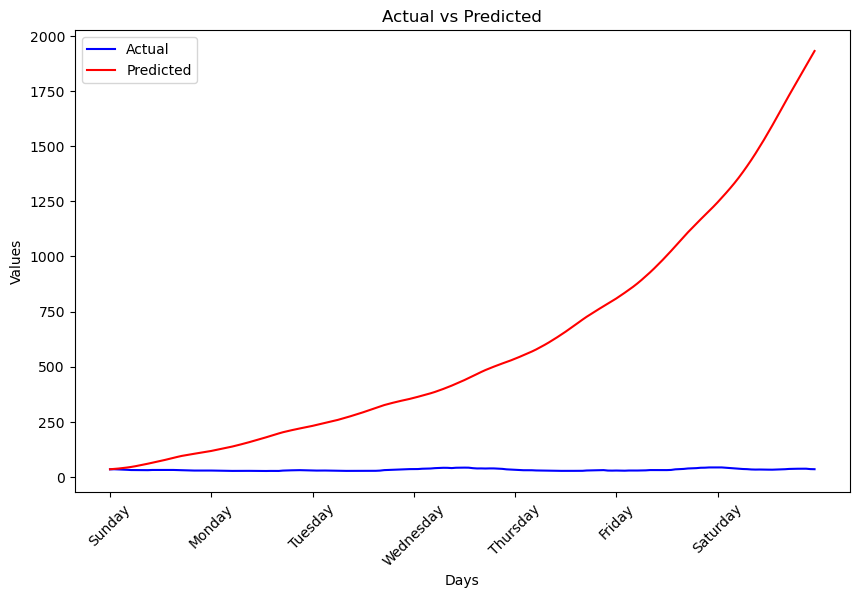

In [55]:
actual_values = [1, 2, 3, 4, 5]

days = [ 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_labels = [days[i//24] for i in range(len(predicted_temperatures))]

plt.figure(figsize=(10, 6))
plt.plot(valData, 'b-', label='Actual')
plt.plot(predicted_temperatures, 'r-', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Days')
plt.ylabel('Values')
plt.xticks(range(0, len(predicted_temperatures), 24), day_labels[::24], rotation=45)
plt.legend(loc='best')
plt.show()

In [53]:
model.save('data/model/h5/model.h5')

In [54]:
del model

In [3]:
model = load_model('data/model/h5/model.h5')

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 24)                2424      
                                                                 
Total params: 43,224
Trainable params: 43,224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# This will print out the signatures of your model
print(list(model.signatures.keys()))

# Assuming 'serving_default' is a key, you can then inspect a specific signature
serving_default = model.signatures['serving_default']
print(serving_default)